# AAI Course: TSNE Visualization (Part V)

## TF-IDF weighted W2V & t-SNE

#### Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & clearning.** The review text is now devoid of punctuations, HTML markups and stop words.

#### Objective:
**To plot t-SNE plot after doing TF-IDF weighted Word2Vec.** The aim is to check whether there is a separation between data points.<br><br>

## Preprocessed Data Loading

In [55]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            import sqlite3
import pdb
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(3))

    index      Id   ProductId          UserId            ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ... 

## Word2Vec & TF-IDF weighted Word2Vec

We need to train our own Word2Vec model using our own text corpus. Word2Vec outputs **a dense matrix with limited number of features**.

Average W2V is done to take the average (w2v vector * TF-IDF) of all the words containing the review.

In [56]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re
#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


#select subset of points for fast execution
num_points = 5000
i=0
list_of_sent=[]

for sent in final['CleanedText'].astype(
    'str', errors='ignore').head(num_points).values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    
    
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

In [58]:
# TF-IDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with 
#    row= sentence, col=word and cell_val = tfidf

# the tfidf-w2v for each sentence/review is stored in this list
tfidf_sent_vectors = []; 
row=0;
for sent in final['CleanedText'].astype(
    'str', errors='ignore').head(num_points).values: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


# t-SNE Visualization

The output of Average W2V is fed into t-SNE for visualization.

In [59]:
# TSNE: perp = 60

from sklearn.manifold import TSNE
from sklearn import preprocessing

#from MulticoreTSNE import MulticoreTSNE as TSNE

#tsne = TSNE(n_jobs=1)#, n_components=2, 
#            random_state=0, perplexity = 100, n_iter = 1000)
#tsne_data = tsne.fit_transform(data_1000)

# standardized_sent_vec = preprocessing.scale(
#        np.nan_to_num(sent_vectors[1:num_points]))

model = TSNE(n_components=2, verbose=2, 
             random_state=0, perplexity = 30, n_iter = 1000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(np.nan_to_num(tfidf_sent_vectors))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.100s...
[t-SNE] Computed neighbors for 5000 samples in 4.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.552s
[t-SNE] Iteration 50: error = 120.3466873, gradient norm = 0.2637243 (50 iterations in 18.310s)
[t-SNE] Iteration 100: error = 119.7920914, gradient norm = 0.3503098 (50 iterations in 19.785s)
[t-SNE] Iteration 150: error = 122.2819901, gradient norm = 0.3093867 (50 iterations in 21.293s)
[t-SNE] Iteration 200: error = 124.5627518, gradient norm = 0.2877098 (50 iterations in 20.274s)
[t-SNE] Iteration 250: error = 120.8936310, gradient norm = 

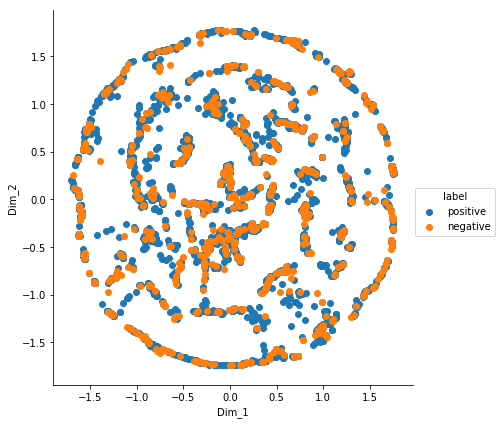

In [60]:
#To plot the t-sne data

labels_1000 = final['Score'].head(num_points)

# creating a new data frame which help us in ploting the result data
tsne_data_wlabel = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data_wlabel, columns=["Dim_1", "Dim_2", "label"])

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(
        plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

## t-SNE Plot: 2nd Run with different Perp Value

[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.120s...
[t-SNE] Computed neighbors for 5000 samples in 4.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 3.610s
[t-SNE] Iteration 50: error = 98.5408401, gradient norm = 0.3841390 (50 iterations in 34.554s)
[t-SNE] Iteration 100: error = 103.9144821, gradient norm = 0.3397610 (50 iterations in 34.469s)
[t-SNE] Iteration 150: error = 100.9618530, gradient norm = 0.3826257 (50 iterations in 39.453s)
[t-SNE] Iteration 200: error = 101.9538040, gradient norm = 0.3351012 (50 iterations in 36.075s)
[t-SNE] Iteration 250: error = 100.2708893, gradient norm = 

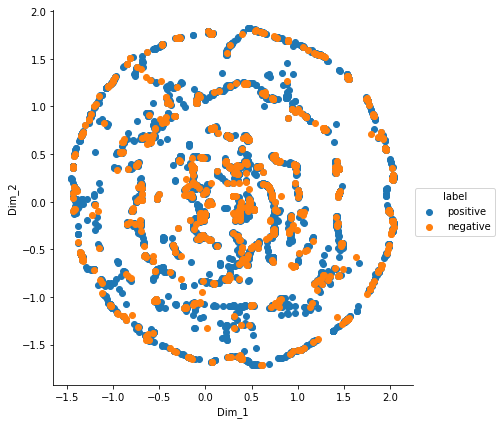

In [61]:

#To run t-sne with diff perp value = 75

model = TSNE(n_components=2, verbose=2, 
             random_state=0, perplexity = 75, n_iter = 1000)

tsne_data = model.fit_transform(np.nan_to_num(tfidf_sent_vectors))

# creating a new data frame which help us in ploting the result data
tsne_data_wlabel = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data_wlabel, 
                       columns=["Dim_1", "Dim_2", "label"])

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(
    plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


## Main Challenges Encountered:

1) **Heavy memory usage of t-SNE:**
In my personal box with 4GB memory, t-SNE was giving frequent memory exceptions, which is obvious. Even after reducing the data points to a subset of < 5K, the program was throwing memory exception.

- **Solution Found:** Ran the code in "Google Colabs" Platform. The platform enabled me to use > 10GB memory and to run the code faster. But there are some hiccups which I faced such as frequent disconnections and kernel dying after 12-13GB memory usage. Also, packages need to be re-installed on every fresh run.

2) **Time Complexity of t-SNE:**
t-SNE was taking **so many hours to execute. But we have to run t-SNE many times for different perplexity values and steps**, to check whether any shape or separation is coming out.

- **Solution Found:** Used the Multicore-TSNE implementation which does parallelization of t-SNE algorithm using multiple cores. The dataset is pretty huge having 3,64,000 data points. We have downsampled the data to 5-25K for faster execution. This significantly reduced execution time.


3) **Interfacing in Google Colabs:**
The input file in google colabs cannot be loaded from local drives. It is capable to fetch the file from google cloud or gdrive. But google cloud is expensive and in gdrive connection is less stable.

- **Solution Found:** Installed a Drive FUSE wrapper & authorised tokens for colab to load the google drive as a fuse filesystem. After loading the file system, we can get all the input files from the 'drive/' directory as if in a local drive. **(code attached as 'Google_colab_dump.pdf')**



# Conclusion

1. t-SNE was executed with **different perplexity and step values for BoW, TF-IDF, W2V & TF-IDF weighted W2V.** The output t-sne plot with different parameters are **given in 'tsne_plots.pdf' file** (separately)
2. **Using TF-IDF weighted W2V, we can find some structure of the data, but separation is not there, using any of the above 4 methods.**
3. It is to be noted that **if the underlying data in original dimension is overlapped, then tsne plots will also reflect the same in lower dimensions.**